## Part II: CNN-LSTM for Sequence Prediction
### Introduction:

- In this section, you will extend the CNN from section (1) to a hybrid CNN-LSTM model to predict the future elements of a sequence.
- Instead of providing a single digit image to predict its category, you will be given a sequence of digit images. These sequences follow a pattern in that each consecutive image pair will be shifted by some constant amount. You will design a CNN-LSTM model to recognize those patterns from raw images and predict the future digits.
- For instance, the input and target of the CNN-LSTM model can be the image squence whose categories are shown as below: 
            Input: 1,3,5,7,9,1   Target: 3,5,7  (shifted by 2)
            Input: 2,6,0,4,8,2   Target: 6,0,4  (shifted by 4)
where the input and target consists of 5 elements and 3 elements, respectively.
- The training sequences are generated by varying shifts.  We will also include some unseen shifts in test sequences to validate the model's generalization ability.

### Task:
- You need to design the model and complete the training loop with Pytorch.
- You need to achieve 93% averaged Top1 Acc on test data.
- This experiment shares the same dataset with the first section. Once you prepare the data following the first section, you do not need to download extra content. 


In [ ]:
# The arguments of the experiment
class Args:
    def __init__(self):
        # Based on the availablity of GPU, decide whether to run the experiment on cuda or cpu.
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # The random seed for the exp.
        self.seed = 1
        # The mini batch size of training and testing data. If you find you machines run very slow 
        # or experinece with OOM issue, you can set a smaller batch size
        self.batch_size = 50
        # The epochs of the exps. The referenced model achieve over 95% test accuracy after 1 epoch.
        self.epochs = 1
        # The learning rate of the SGD optimizer
        self.lr = 0.1
        # The momentum of SGD optimizer
        self.momentum = 0.5
        # how many iterations to display the training stats
        self.log_interval = 10
        # The height of input image
        self.img_h = 28
        # The width of the input image
        self.img_w = 28
        # The length of input sequence
        self.input_seq_len = 5
        # The lenght of the sequence to predict
        self.target_seq_len = 2
        # The list to sample shift to generate the training sequence.
        self.train_shift_list = [1,2,4,5]
        # The list to sample shift to generate the testing sequence. 
        self.test_shift_list = [1,2,3,4,5]

In [ ]:
# pytorch mnist cnn + lstm
# Load necessary library

from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data.dataset import Dataset 
from torch.autograd import Variable
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt 
args = Args()
torch.manual_seed(args.seed)

### 0. The dataloader
- Load the data from csv file
- Generate the input and target image sequences spaced by constant distance sampled from the predefined shift list

In [ ]:
# The dataset to generated training and testing sequence
class MNIST_SEQ_DATASET(Dataset):
    def __init__(self, csv_path, height, width, input_len, output_len, seq_shift, transform=None):
        """
        Custom dataset example for reading data from csv

        Args:
            csv_path (string): path to csv file
            height (int): image height
            width (int): image width
            transform: pytorch transforms for transforms and tensor conversion
        """
        self.data = pd.read_csv(csv_path)
        self.labels = np.asarray(self.data.iloc[:, 0])
        self.height = height
        self.width = width
        self.input_len = input_len
        self.output_len = output_len
        self.transform = transform
        self.seq_shift = seq_shift
        unique_label_array = np.unique(self.labels)
        self.label_data_id_dict = {}
        for unique_label in unique_label_array:
            self.label_data_id_dict[unique_label] = np.where(self.labels == unique_label)[0]   
        
    def get_single_image(self, index):
        single_image_label = self.labels[index]
        # Read each 784 pixels and reshape the 1D array ([784]) to 2D array ([28,28])
        img_as_np = np.asarray(self.data.iloc[index][1:]).reshape(28, 28).astype('uint8')
        # Convert image from numpy array to PIL image, mode 'L' is for grayscale
        img_as_img = Image.fromarray(img_as_np)
        img_as_img = img_as_img.convert('L')
        # Transform image to tensor
        if self.transform is not None:
            img_as_tensor = self.transform(img_as_img)
        # Return image and the label
        return (img_as_tensor, single_image_label)
    
    def __getitem__(self, index):
        # Randomly sample the shift from predefined shift list
        seq_shift = np.random.choice(self.seq_shift)
        # Randomly select one category as leading digit
        start_idx = np.random.choice(10)
        # The sequence with following digits
        seq_digit = np.arange(start_idx, start_idx + seq_shift * (self.input_len + self.output_len), seq_shift)
        # Modulo opeartion over the digit sequence
        seq_digit = seq_digit % 10
        img_seq = []
        label_seq = []
        # Collect the images for each digit
        for digit in seq_digit:
            data_id = np.random.choice(self.label_data_id_dict[digit])
            img, label = self.get_single_image(data_id)
            img_seq.append(img)
            label_seq.append(label)
        # Return image and the label
        input_img_seq = img_seq[:self.input_len]
        input_label_seq = label_seq[:self.input_len]
        target_img_seq = img_seq[self.input_len:]
        target_label_seq = label_seq[self.input_len:]
        return torch.stack(input_img_seq), torch.stack(target_img_seq), \
                torch.from_numpy(np.stack(input_label_seq)), \
                torch.from_numpy(np.stack(target_label_seq)), \
                seq_shift

    def __len__(self):
        return len(self.data.index)

In [ ]:
# Instantiate the dataset which is then wrapperd by the DataLoader for effective prefecting
transformations = transforms.Compose([transforms.ToTensor()])
mnist_train = \
    MNIST_SEQ_DATASET('./mnist_train.csv',
                             args.img_h, args.img_w, args.input_seq_len, args.target_seq_len,
                             args.test_shift_list,
                             transformations)

mnist_test = \
    MNIST_SEQ_DATASET('./mnist_test.csv',
                             args.img_h, args.img_w, args.input_seq_len, args.target_seq_len,
                             args.test_shift_list,
                             transformations)

mnist_train_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                                    batch_size=args.batch_size,
                                                    shuffle=True)

mnist_test_loader = torch.utils.data.DataLoader(dataset=mnist_test,
                                                    batch_size=args.batch_size,
                                                    shuffle=False)

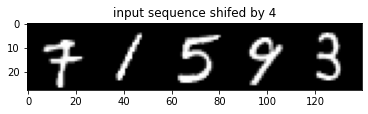

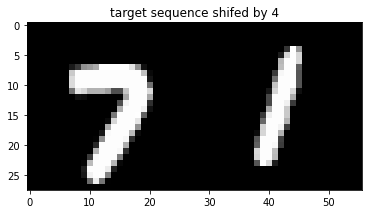

In [ ]:
# Display the input sequence and target sequence
input_img_seq, target_img_seq, input_label_seq, target_label_seq, seq_shift = mnist_train[0]
img_to_disp = input_img_seq.permute(1,2,0,3).reshape(args.img_h,-1,args.img_w)
input_img_seq = img_to_disp.reshape(args.img_h, -1)
img_to_disp = target_img_seq.permute(1,2,0,3).reshape(args.img_h,-1,args.img_w)
target_img_seq = img_to_disp.reshape(args.img_h, -1)
plt.imshow(input_img_seq,  cmap="gray")
plt.title('input sequence shifed by {}'.format(seq_shift))
plt.show()
plt.imshow(target_img_seq, cmap="gray")
plt.title('target sequence shifed by {}'.format(seq_shift))
plt.show()

### 1. (TODO) The CNN-LSTM Model [20 points]
- Complete the following section to create a CNN-LSTM model for the sequence prediction problem. 
- You can borrow the CNN design from previous section as the CNN encodes the categorical features of the image
- The CNN-LSTM should consist of the three modules: 
    - CNN for extracting visual features to a single feature vector
    - LSTM taking as input the sequence of feature vectors from CNN and producing a hidden state suitable to predict the next element
    - A decoder to convert the LSTM hidden state to a categorical prediction

In [ ]:

class CNN(nn.Module):
    """Custom CNN model to extract visual features from input image"""
    
    def __init__(self):
        """ Define and instantiate your layers"""
        super(CNN, self).__init__()s
        # YOUR CODE HERE
    def forward(self, x):
        """ 
        Run forward pass on input image X
        
        Args:
            x: torch tensor of input image, 
                with shape of [batch_size, 1, img_h, img_w]
        
        Return:
            out: torch tensor of feature vector computed on input image, 
                with shape of [batch_size, latent_dim]
         
        """
        # YOUR CODE HERE


class CNN_LSTM(nn.Module):
        """ Custom CNN-LSTM model for sequence prediction problem """
    def __init__(self):
        """ Define and instantiate your layers"""
        super(CNN_LSTM, self).__init__()
        # YOUR CODE HERE

    def forward(self, x, num_step_to_predict):
        """ 
        Run forward pass on image squence x and predict the future digits
        
        Args:
            x : torch tensor of input image sequence, 
                    with shape of [batch_size, input_time_step, 1, img_h, img_w]
            num_step_to_predict: an interger on how many steps to predict. 
            
        Returns:
            output: torch tensor of predicted categorical distribution  
                    for the ENTIRE sequence, including input and predicted sequence, 
                    with shape of [batch_size, input_time_step + num_step_to_predict, 10].
                    Noted the output from i step is the prediction for 1+1 step. 
            
        """
        # YOUR CODE HERE

### 2. (TODO) The Training Loop [15 points]
- Instantiate the model and optimizer
- Select proper loss function for this task
- Complete the training loop

In [ ]:
model = CNN_LSTM()
model = model.to(args.device)
optimizer = # YOUR CODE HERE


def train(epoch):
    model.train()
    for batch_idx, (input_img_seq, target_img_seq, input_label_seq, target_label_seq, seq_shift) in enumerate(mnist_train_loader):
        # batch_size * input_seq_len * 1 * img_h * img_w
        input_img_seq = input_img_seq.to(args.device)
        # batch_size * input_seq_len
        input_label_seq = input_label_seq.to(args.device)
        # batch_size * output_seq_len * 1 * img_h * img_w
        target_img_seq = target_img_seq.to(args.device)
        # batch_size * output_seq_len
        target_label_seq = target_label_seq.to(args.device)
        
        # YOUR CODE HERE

for epoch in range(args.epochs):
    train(epoch)

## 3. Test 
- Once your model achieve descent training accuracy, you can run test to validate your model
- You should achieve at least 93% Top1 Acc to get full credit.

In [ ]:
def test():
    model.eval()
    top1_acc_dict = {test_shift:{'sum_acc':0, 'count':0} for test_shift in args.test_shift_list}
    top5_acc_dict = {test_shift:{'sum_acc':0, 'count':0} for test_shift in args.test_shift_list}
    for batch_idx, (input_img_seq, target_img_seq, input_label_seq, target_label_seq, seq_shift) in enumerate(mnist_test_loader):
        batch_size = input_img_seq.shape[0]
        # batch_size * input_seq_len * 1 * img_h * img_w
        input_img_seq = input_img_seq.to(args.device)
        # batch_size * input_seq_len
        input_label_seq = input_label_seq.to(args.device)
        # batch_size * output_seq_len * 1 * img_h * img_w
        target_img_seq = target_img_seq.to(args.device)
        # batch_size * output_seq_len
        target_label_seq = target_label_seq.to(args.device)
        
        total_pred = model(input_img_seq, args.target_seq_len)
        pred = total_pred[:,:-1][:,-1 * args.target_seq_len:].reshape(-1,10)

        _, top_index = pred.topk(5, dim = -1)
        correct_pred = top_index == target_label_seq.reshape(-1)[:,None]
        top1_acc = correct_pred[:,0].float().reshape(batch_size, -1) * 100
        top5_acc = correct_pred[:,:5].sum(dim = -1).float().reshape(batch_size, -1) * 100
        for seq_shift_ele in torch.unique(seq_shift):
            top1_acc_val = top1_acc[torch.where(seq_shift == seq_shift_ele)[0]].mean(dim = -1).sum()
            top1_acc_count = torch.where(seq_shift == seq_shift_ele)[0].shape[0]
            top1_acc_dict[seq_shift_ele.item()]['sum_acc'] += top1_acc_val.item()
            top1_acc_dict[seq_shift_ele.item()]['count'] += top1_acc_count
            
            top5_acc_val = top5_acc[torch.where(seq_shift == seq_shift_ele)[0]].mean(dim = -1).sum()
            top5_acc_count = torch.where(seq_shift == seq_shift_ele)[0].shape[0]
            top5_acc_dict[seq_shift_ele.item()]['sum_acc'] += top5_acc_val.item()
            top5_acc_dict[seq_shift_ele.item()]['count'] += top5_acc_count 

        total_top1_acc = np.mean(np.stack([val['sum_acc'] / (val['count'] + 1e-5) for key, val in top1_acc_dict.items()]))
        total_top5_acc = np.mean(np.stack([val['sum_acc'] / (val['count'] + 1e-5) for key, val in top5_acc_dict.items()]))
        
        if batch_idx % args.log_interval == 0:
            print('Test: [{}/{} ({:.0f}%)] Top1 Acc: {:1f}, Top5 Acc: {:1f}'.format(
                batch_idx * input_img_seq.shape[0], len(mnist_test_loader.dataset),
                100. * batch_idx * input_img_seq.shape[0] / len(mnist_test_loader.dataset), total_top1_acc, total_top5_acc))
        
    top1_acc_each_shift = np.stack([val['sum_acc'] / (val['count'] + 1e-5) for key, val in top1_acc_dict.items()])
    top5_acc_each_shift = np.stack([val['sum_acc'] / (val['count'] + 1e-5) for key, val in top1_acc_dict.items()])
    for idx, (key, _) in enumerate(top1_acc_dict.items()):
        print('Shift {}, Test Top1 Acc: {:1f}, Test Top5 Acc: {:1f}'.format(key, top1_acc_each_shift[idx], top5_acc_each_shift[idx]))
test()